In [1]:
import numpy as np 
import scanpy as sc 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [3]:
del adata.uns['received_ligands']
del adata.uns['received_ligands_tfl']

adata.uns['cell_thresholds'] = pd.DataFrame(
    index=adata.obs.index, 
    columns=adata.var_names).fillna(1)

/tmp/ipykernel_22294/2949346289.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.uns['cell_thresholds'] = pd.DataFrame(


In [4]:
adata.obs['banksy_celltypes'].value_counts()

banksy_celltypes
T_CD4                   1093
B_memory                 909
GC Light Zone            726
B_naive                  712
GC Dark Zone             560
GC Intermediate Zone     457
T_follicular_helper      334
plasma                   274
mDC/myeloid              240
FDC                      220
T_CD8                    198
pDC                       55
Name: count, dtype: int64

### Create matching plots

In [5]:
# adata.obs['banksy_celltypes'].value_counts()

In [6]:
color_dict = {
    'CD4+ T': "#ea7465",
    'Tfh': "#b74329", 
    'CD8+ T': "#dd3652",
    'T cells': "#7a4711",
    'GC Intermediate Zone': "#e28723",
    'GC Dark Zone': "#147ee9",
    'GC Light Zone': "#f309c5",
    'GC B': "#6a064f",
    'B memory': "#61c17c",
    'B naive': "#4b9131", 
    'Plasma': "#beb637",
    'T memory': "#98907f",
}


import sys 
sys.path.append('/ix3/djishnu/alw399/SpaceOracle/src')
from spaceoracle.plotting.cartography import Cartography


2025-06-12 17:50:21.217520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [7]:
adata_ = adata[adata.obs['banksy_celltypes'].isin(['GC Intermediate Zone','GC Dark Zone','GC Light Zone'])]
adata_

View of AnnData object with n_obs × n_vars = 1743 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [8]:
adata.shape, adata_.shape

((5778, 3333), (1743, 3333))

In [9]:
chart = Cartography(adata_, color_dict)

In [10]:
goi = 'FOXO1'

# SpaceTravLR
simulated_df = pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_tonsil_scGPT_pretrained/{goi}_4n_0x.parquet').loc[adata_.obs.index]
method = 'scGPT_spatial'

In [11]:
delta_X = (simulated_df - chart.unperturbed_expression).values
gene_mtx = chart.unperturbed_expression.values
gene_mtx.shape, delta_X.shape

((1743, 3333), (1743, 3333))

In [12]:
corr = chart.compute_perturbation_corr(gene_mtx, delta_X)
null_corr =  chart.compute_perturbation_corr(gene_mtx, delta_X * 0)
corr.shape

(1743, 1743)

In [13]:
import alphashape
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import seaborn as sns 
from shapely.geometry import Point

In [14]:
chart.adata.obs['banksy_celltypes'].unique()

['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone']
Categories (3, object): ['GC Dark Zone', 'GC Intermediate Zone', 'GC Light Zone']

In [15]:
try:
    chart.adata.obs.drop(['transition'], axis=1, inplace=True)
except:
    pass

In [16]:
chart.get_transition_annot(
    corr, 
    allowed_fates=chart.adata.obs['banksy_celltypes'].unique(), 
    thresh=0, 
    annot='banksy_celltypes'
)

100%|██████████| 726/726 [00:26<00:00, 27.05it/s]


source ct GC Light Zone Counter({'GC Light Zone': 712, 'GC Dark Zone': 14}) 6.28481606408966e-05 0.0


100%|██████████| 457/457 [00:14<00:00, 32.51it/s]


source ct GC Intermediate Zone Counter({'GC Light Zone': 452, 'GC Dark Zone': 5}) 0.0007745245990559099 0.0


100%|██████████| 560/560 [00:17<00:00, 32.43it/s]


source ct GC Dark Zone Counter({'GC Light Zone': 555, 'GC Dark Zone': 5}) 0.0006948659174090958 0.0


In [17]:
xy = pd.DataFrame(adata.obsm['spatial'], index=adata.obs.index, columns=['x', 'y'])

In [18]:
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [19]:
ct_points_wt, ct_points_ko = chart.make_celltype_dict(annot='banksy_celltypes')

In [20]:
alpha_shape_0 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.05)
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.05)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.05)

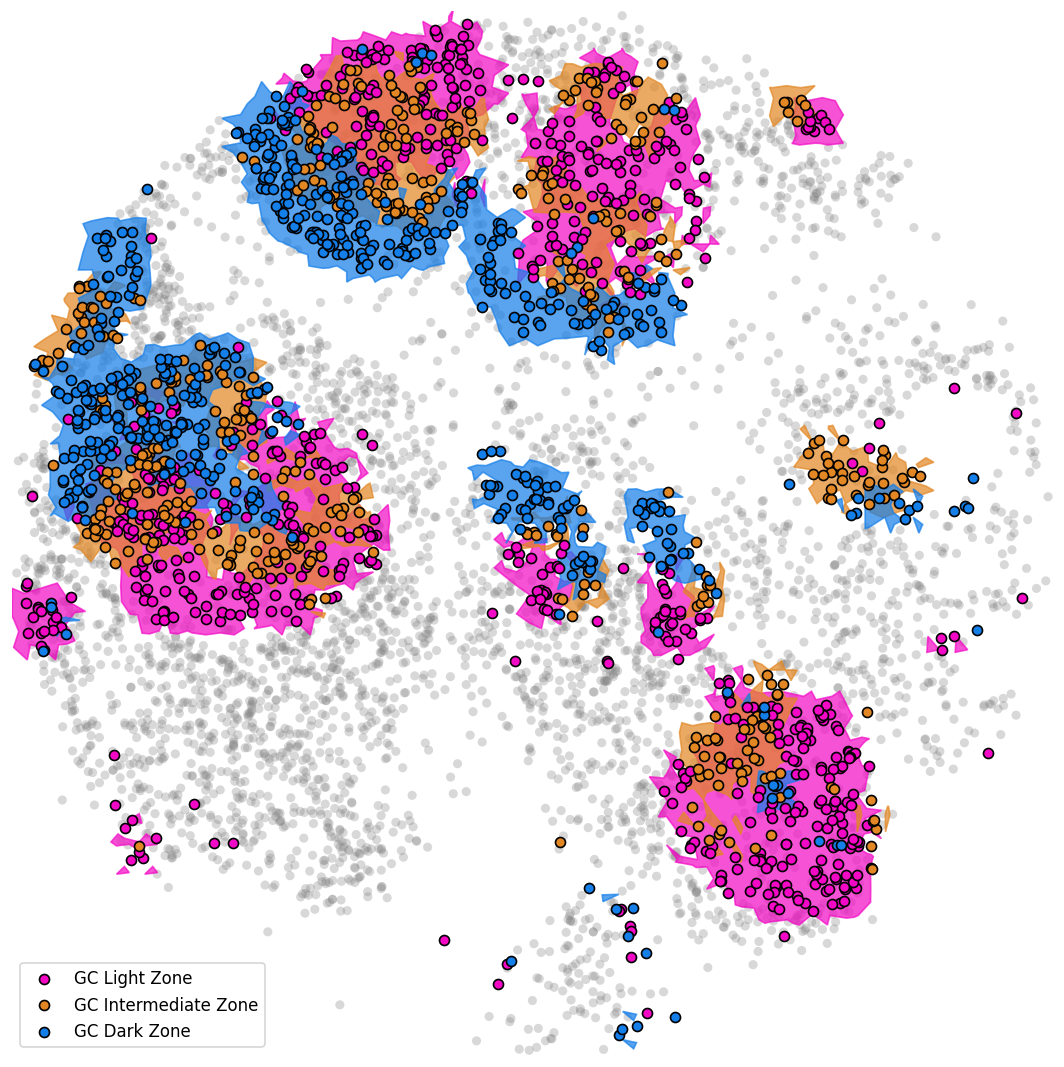

In [21]:
fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 150

for cluster, alpha_shape in zip(['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone'],
                                [alpha_shape_2, alpha_shape_0, alpha_shape_1]):
    try:
        for geom in alpha_shape.geoms:
            if geom.area > area_thresh:
                ax.fill(
                    geom.exterior.xy[0], 
                    geom.exterior.xy[1], 
                    color=color_dict[str(cluster)], alpha=zone_alpha)
    except:
        geom = alpha_shape
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict[str(cluster)], alpha=zone_alpha
        )

for ct in chart.adata.obs['banksy_celltypes'].unique():
    ax.scatter(
        adata[adata.obs['banksy_celltypes'] == ct].obsm['spatial'][:, 0],
        adata[adata.obs['banksy_celltypes'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
plt.tight_layout()

# plt.savefig(f'human_tonsil_{goi}KO_preKO_{method}.svg', format='svg')

In [22]:
ct_points_ko.keys()

dict_keys(['GC Light Zone', 'GC Dark Zone'])

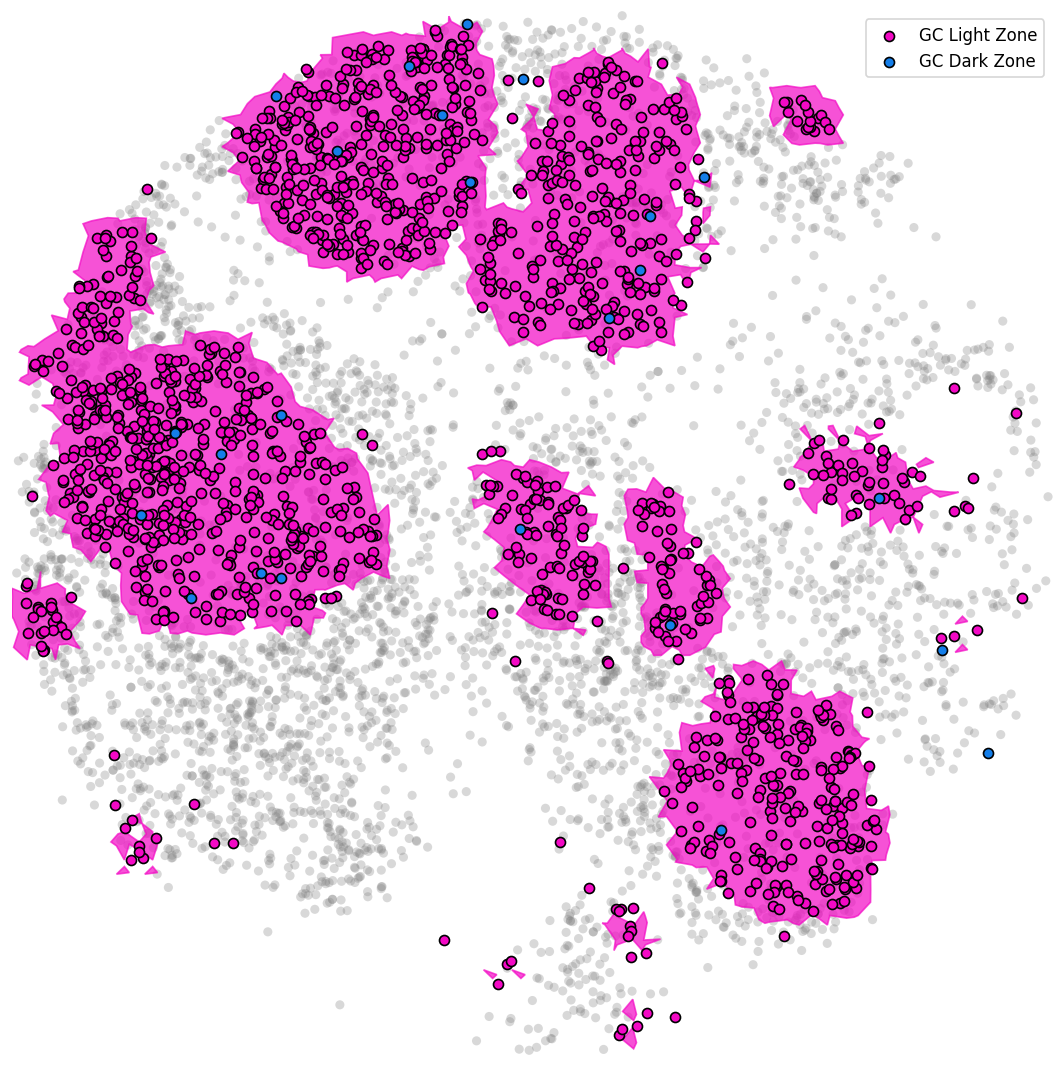

In [23]:
try:
    alpha_shape_0 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.05)
except:
    alpha_shape_0 = None
try:
    alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.05)
except:
    alpha_shape_1 = None
alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.05)

fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 150

for cluster, alpha_shape in zip(['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone'],
                                [alpha_shape_2, alpha_shape_0, alpha_shape_1]):
    if alpha_shape is None:
        continue
    try:
        for geom in alpha_shape.geoms:
            if geom.area > area_thresh:
                ax.fill(
                    geom.exterior.xy[0], 
                    geom.exterior.xy[1], 
                    color=color_dict[str(cluster)], alpha=zone_alpha)
    except:
        geom = alpha_shape
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict[str(cluster)], alpha=zone_alpha
        )

for ct in chart.adata.obs['transition'].unique():
    ax.scatter(
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 0],
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
plt.tight_layout()

plt.savefig(f'human_tonsil_scGPT_pretrained_{goi}KO_postKO_{method}.svg', format='svg')

In [24]:
# adata = chart.adata
chart.adata.obs['leiden'] = adata.obs['banksy_celltypes']

In [25]:
chart.adata.obs['leiden'] = chart.adata.obs['leiden'].cat.remove_unused_categories()
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition']=chart.adata.obs['transition'].cat.remove_unused_categories()

In [26]:
df = chart.adata.obs[['leiden', 'transition']].copy()
counts = df.groupby(['leiden', 'transition']).size().unstack(fill_value=0)

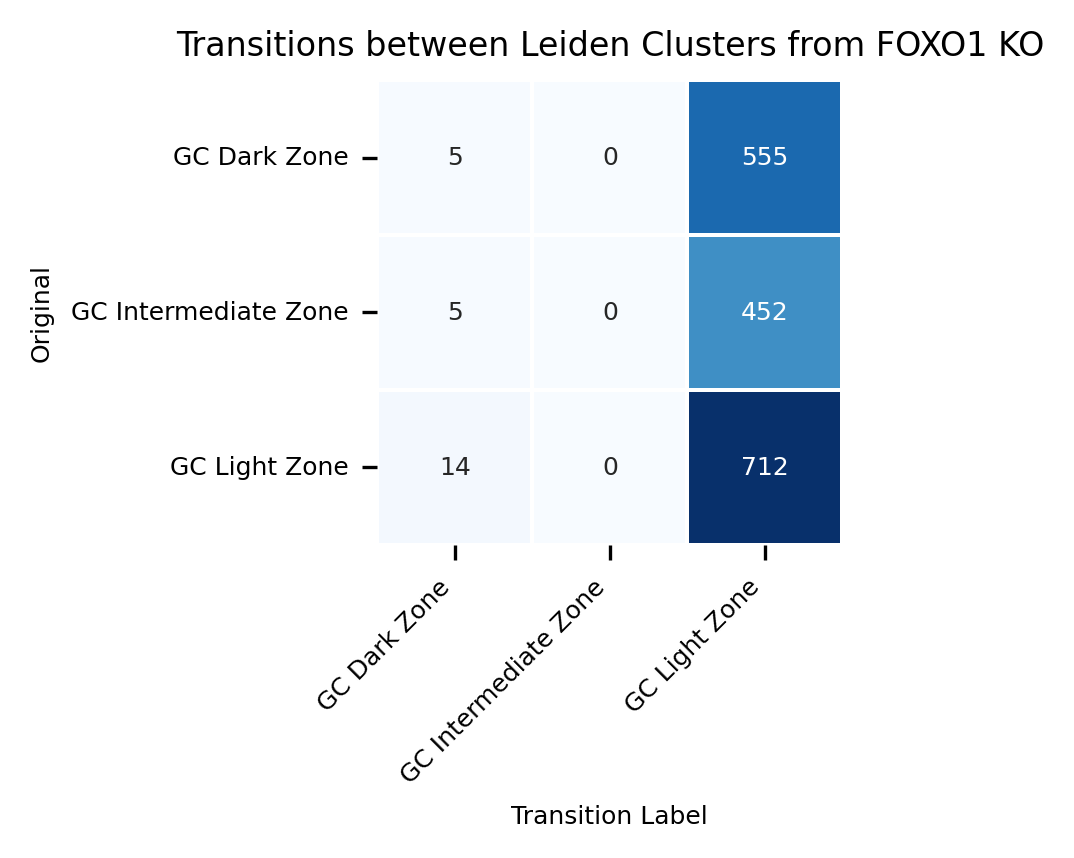

In [27]:
plt.figure(figsize=(3,3), dpi=300)

# Ensure counts has same number of rows and columns
if counts.empty:
    # Create empty DataFrame with same index and columns
    counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
elif len(counts.index) != len(counts.columns):
    # Add missing rows/columns with zeros
    all_labels = sorted(set(counts.index) | set(counts.columns))
    counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # Changed to integer format
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title(f"Transitions between Leiden Clusters from {goi} KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
plt.savefig(f'human_tonsil_scGPT_pretrained_{goi}KO_transitions_{method}.svg', format='svg')
plt.show()

In [28]:
method

'scGPT_spatial'